<a href="https://colab.research.google.com/github/pablocontini/Taller-de-Procesamiento-de-Datos/blob/main/TPS06_%C3%81rboles_y_Bosques_Aleatorios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enunciado

**Árboles de decisión**

Tres productores de vino, de la mima región de Italia, sometieron su producto a un análisis químico. Se desea clasificar el productor correspondiente a partir del análisis mencionado.

(a) *Exploración de datos*: Cargar la base de datos utilizando $\texttt{load_wine}$ (sklearn).

(b) *Árbol de decisión*:

- Utilizando el comando `tree.DecisionTreeClassifier` (sklearn), entrenar un clasificador con entropía como función de impureza.
- Utilizando $\texttt{plot_tree}$ (sklearn) graficar el diagrama de árbol. Inidicar la cantidad de nodos y hojas.
- Encontrar los 3 *features* más relevantes según la *Feature Importance*.
- Clasificar el siguiente análisis químico:

  $13.0$, $2.33$, $2.37$, $19.5$, $99.7$, $2.29$, $2.03$, $0.36$, $1.59$, $5.06$, $0.96$, $2.61$, $747$

(c) *Podado*: Repetir el inciso (b) para un árbol podado con una complejidad $\alpha=0.05$. Calcular el *costo-complejidad* asociado.

(d) *Bosques aleatorios*: Implementar un bosque aleatorio de 30 árboles (sin poda) con entropía como función de impureza. Puede utilizar el comando `tree.DecisionTreeClassifier` (sklearn) pero la combinación de estos árboles debe ser implementación propia. El código debe estar estructurado de la siguiente manera:

```python
class RandomForest:

  # Inicializar atributos y declarar hiperparámetros
  def __init__(self,...

  # Etapa de entrenamiento
  def fit(self, X, y):

  # Etapa de testeo hard
  def predict(self, X):
```

Clasificar el análisis químico del inciso (b).

# (a) Exploración de datos

Para el desarrollo de este trabajo práctico se utilizará el dataset **Wine** de *scikit-learn*.

**Wine** es un dataset de clasificación multiclase clásico y muy sencillo.
Contiene resultados de un análisis químico de muestras de vino provenientes de tres vitivinicultores distintos de la misma región de Italia.

Cada vino está caracterizado por su clase y trece mediciones diferentes para los distintos componentes presentes en éste sin valores faltantes: Alcohol, Ácido málico, Ceniza, Alcalinidad de las cenizas, Magnesio, Fenoles totales, Flavonoides, Fenoles no flavonoides, Proantocianinas, Intensidad del color, Matiz, OD280/OD315 de vinos diluidos y Prolina.

Contiene 59, 71 y 48 muestras de las clases 0, 1 y 2 respectivamente, es decir, está moderadamente balanceado, aunque no perfectamente.

A continuación, se carga el dataset, las matrices de atributos y etiquetas, se revisa su dimensión y se comprueba cuántas clases y variables químicas hay.


In [ ]:
import numpy as np
from sklearn.datasets import load_wine

# Carga del dataset
wine = load_wine()

# Separa las características (X) y la variable objetivo (y)
X, y = wine.data, wine.target

# Obtiene los nombres de los Features
feature_names = wine.feature_names

# Obtiene los nombres de las clases objetivo
target_names = wine.target_names

print(f"Dataset: {X.shape[0]} vinos – {X.shape[1]} variables – {len(np.unique(y))} productores\n")

Dataset: 178 vinos – 13 variables – 3 productores



# (b) Árbol de decisión

Los **árboles de decisión** son un tipo de método basado en árboles que se utilizan para la clasificación. Funcionan haciendo una serie de preguntas o tests, que típicamente son binarios, para clasificar una muestra de datos.

El proceso de clasificación arranca en el **nodo raíz**. Las preguntas o *splits* pueden ser divisiones simples, como si un feature es menor o igual a un valor determinado ($x_j\leq s$), o incluso combinaciones lineales de features ($\sum a_jx_j\leq s$), aunque estas últimas pueden afectar la interpretabilidad. Según la respuesta, se sigue el enlace apropiado a un **nodo descendiente**. El proceso continúa hasta alcanzar un **nodo hoja**, que asigna la muestra a una categoría.

La construcción del árbol ("crecer" un árbol) se basa en **datos de entrenamiento etiquetados**. La idea es dividir progresivamente el conjunto de datos de entrenamiento en subconjuntos más pequeños en cada nodo.

En este proceso, se busca una prueba o test en cada nodo que haga que los datos que llegan a los nodos descendientes inmediatos sean lo más "puros" posible, es decir, que todas las muestras en ese nodo tengan la misma etiqueta de categoría.

Para formalizar esta idea, se define la **impureza** de un nodo. Las medidas de impureza buscan ser **cero si todas las muestras tienen la misma etiqueta** y grandes si las categorías están igualmente representadas.

Una de las medidas más populares es la **impureza de entropía**. Para el conjunto de datos en un nodo $m$ ($Q_m$), la impureza de entropía se define como:
$$H(Q_m)=\sum_k-p_{m,k}\log_2(p_{m,k})$$
donde $p_{m,k}$ es la fracción de muestras en el nodo $m$ que pertenecen a la categoría $k$.

Además de la entropía, existen otras medidas de impureza como la de Gini.

La elección de la mejor prueba o split (división) en un nodo se basa en elegir, para cada nodo, el feature $j_m$ y el umbral $t_m$, de modo **maximizar la reducción de la impureza** (o "ganancia de información"). Para esto se define el costo tras dividir el nodo:

$$G_m(j_m,t_m)=\frac{\left\lvert Q_m^L(j_m,t_m)\right\rvert}{\left\lvert Q_m\right\rvert}H\left(Q_m^L(j_m,t_m)\right)+\frac{\left\lvert Q_m^R(j_m,t_m)\right\rvert}{\left\lvert Q_m\right\rvert}H\left(Q_m^R(j_m,t_m)\right)$$

Este valor es el promedio ponderado de las impurezas de los dos subconjuntos que resultan de hacer la división.

El par óptimo $(j_m^\ast,t_m^\ast)$ es el que minimiza esa cantidad:
$$(j_m^\ast,t_m^\ast)=\arg\min_{j_m,t_m}G_m(j_m,t_m)$$

En la práctica esto significa que, en cada paso del árbol de decisión, se prueba cada feature y cada valor posible como punto de corte para ver cuál logra separar mejor las clases (es decir, cuál produce subconjuntos más "puros"). El objetivo final es que cada hoja del árbol contenga principalmente (o exclusivamente) muestras de una única clase.


Para evitar el sobreajuste ("overfitting") y mejorar la capacidad de generalización del modelo, se pueden emplear técnicas para detener el crecimiento del árbol antes de que las hojas sean completamente puras ("stopped splitting").

Algunas de las condiciones de parada más comunes son:

- **Pureza total**: si todas las muestras en el nodo pertenecen a la misma clase ya no hay necesidad de dividir, el nodo es una **hoja pura**.
- **Máxima profundidad**: se fija un número máximo de niveles del árbol.
- **Cantidad mínima de muestras para dividir un nodo**: si un nodo contiene menos de un número predefinido de muestras, se decide no dividirlo.
- **Cantidad mínima de muestras en una hoja**: una división a cualquier profundidad se considerará si deja al menos cierta cantidad de muestras en cada rama izquierda y derecha.  
- **Ganancia de impureza mínima**: si al dividir no se logra una reducción en la impureza significativa, se detiene.

En `DecisionTreeClassifier` de scikit-learn, estas condiciones están controladas por hiperparámetros como: `max_depth`, `min_samples_split`, `min_samples_leaf`, `min_impurity_decrease`, etc.

## Entrenamiento del clasificador

A continuación, se entrena un **árbol de decisión** utilizando la entropía como criterio de impureza.

Como el enunciado no menciona otra condición de parada, el criterio es el de pureza total.

Se establece `random_state=0` para obtener el mismo comportamiento en cada ejecución del entrenamiento. Es decir, si en una división la mejora del criterio es idéntica para varias divisiones y una de ellas debe seleccionarse aleatoriamente.


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Crea un objeto DecisionTreeClassifier con:
# - criterion='entropy': usa la entropía para medir la impureza de los nodos.
# - random_state=0: asegura que el árbol se construya de la misma forma cada vez.
dt = DecisionTreeClassifier(criterion='entropy', random_state=0)

# Entrena el clasificador
dt.fit(X, y)


NameError: name 'X' is not defined

## Estructura completa del árbol

Se muestra su estructura completa con `plot_tree`.

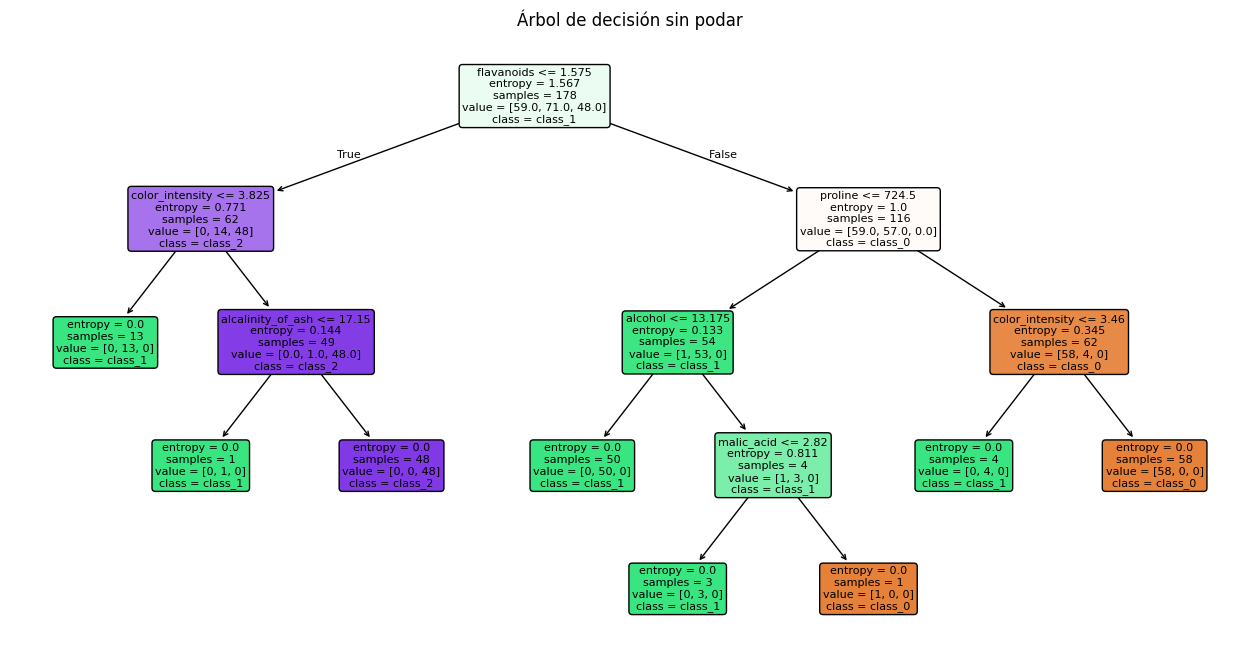

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


# Diagrama del árbol
plt.figure(figsize=(16, 8))
plot_tree(
  dt,
  feature_names = feature_names,  # Nombres de cada una de las características
  class_names = target_names,     # Nombres de clase de destino en orden numérico ascendente
  label = 'all',                  # Etiquetas informativas sobre impurezas
  filled = True,                  # Pinta los nodos para indicar la clase mayoritaria
  rounded = True,                 # Cuadros de nodos con esquinas redondeadas
  fontsize = 8
)
plt.title("Árbol de decisión sin podar")
plt.show()


## Número de nodos y hojas

El clasificador tiene un atributo llamado `tree_` que permite acceder a atributos de bajo nivel como `node_count`, el número total de nodos, y `n_leaves`, el número de hojas del árbol de decisión.

De esta manera, puede verse que el árbol posee 15 nodos de los cuales 8 son hojas.

In [ ]:
print(f"Árbol de decisión sin podar – nodos: {dt.tree_.node_count}, hojas: {dt.tree_.n_leaves}")

Árbol de decisión sin podar – nodos: 15, hojas: 8


## Features más relevantes

La importancia de cada feature (o *Gini Importance*) se define como la disminución total de la impureza del nodo, ponderada por la probabilidad de llegar a ese nodo (normalizado).

En la práctica, para cada nodo donde se realiza una división con el feature $j$:
- Se calcula la reducción de impureza:

$$\Delta H=H(Q_m)-\left(\frac{\left\lvert Q_m^L\right\rvert}{\left\lvert Q_m\right\rvert}H\left(Q_m^L\right)+\frac{\left\lvert Q_m^R\right\rvert}{\left\lvert Q_m\right\rvert}H\left(Q_m^R\right)\right)$$
- Se multiplica por la proporción de muestras de ese nodo: $|Q_m|/n$.
- Se suman todas estas contribuciones para el feature $j$ a lo largo del árbol.
- Finalmente, se normaliza para que las importancias sumen 1.

Por lo tanto, un valor alto indica que ese feature fue usado muchas veces y con divisiones efectivas.

En scikit-learn se accede con el atributo `feature_importances_`.

Se observa que los features más importantes son **flavonoids**, **proline** y **color_intensity**. En el diagrama completo del árbol también puede verse cómo las reglas comienzan dividiendo por estos 3 mismos.

In [ ]:
# Obtener los índices de las features ordenadas por importancia (de mayor a menor)
feature_importance_idx = np.argsort(dt.feature_importances_)[::-1]

# Seleccionar los índices de las 3 features más importantes
top3_feature_importance_idx = feature_importance_idx[:3]

# Obtener los nombres de las 3 features más importantes usando los índices
top3_feature_importance_names = [feature_names[i] for i in top3_feature_importance_idx ]


print("Features más relevantes:", top3_feature_importance_names)

Features más relevantes: ['flavanoids', 'proline', 'color_intensity']


## Predicción

A continuación, se procede a clasificar una nueva muestra química compuestas por 13 valores.

El método `predict` recorrerá el árbol desde la raíz hasta una hoja, aplicando en cada nodo una regla de decisión basada en uno de los features.

Al llegar a una hoja, cuenta cuántas muestras de entrenamiento de cada clase hay en esa hoja y obtiene un vector de probabilidades normalizado (`predict_proba`).

Luego simplemente selecciona la clase con mayor probabilidad y asigna a la muestra esa clase (`np.argmax(predict_proba())`).

En este caso, el árbol predijo que la muestra corresponde a `class_0`.

In [ ]:
# Muestra a clasificar
sample = np.array([[13.0, 2.33, 2.37, 19.5, 99.7, 2.29, 2.03, 0.36, 1.59,
                    5.06, 0.96, 2.61, 747]])

pred_dt = dt.predict(sample)[0]
print("Predicción árbol sin podar:", target_names[pred_dt])



Predicción árbol sin podar: class_0


# (c) Podado

El objetivo principal del proceso de poda es **evitar el sobreajuste** (overfitting) a los datos de entrenamiento. Un árbol muy complejo que se ajusta perfectamente a los datos de entrenamiento puede no generalizar bien a nuevos datos, capturando ruidos a patrones específicos de ese conjunto en particular.

El podado busca **simplificar el árbol** eliminando ramas o nodos que no aportan significativamente a la capacidad de generalización. Al hacer esto, se reduce la complejidad del modelo.

El algoritmo de poda de costo-complejidad mínima está parametrizado por $\alpha\geq 0$ conocido como **parámetro de complejidad**. Este parámetro se utiliza para definir la medida de **costo-complejidad**  $H_\alpha(T)$ de un árbol dado $T$:
$$H_\alpha(T)=\sum_{m\in L(T)}\frac{\lvert Q_m\rvert}{n}H(Q_m)+\alpha \lvert L(T)\rvert$$
donde $T$ es el árbol completo, $|L(T)|$ es el número de hojas del árbol, $|Q_m|$ es la cantidad de muestras en la hoja $m$, $H(Q_m)$ es la impureza en nodo $m$ y $n$ es el número total de muestras.

El primer término representa la impureza promedio ponderada del árbol y refleja qué tan bien el árbol se ajusta a los datos de entrenamiento. Es decir, cuanto menor es este término, mejor es el ajuste.

El segundo término penaliza la cantidad de hojas en un árbol. Cuanto más grande es $\alpha$, **más costoso es tener muchas hojas**


En scikit-learn, el parámetro `ccp_alpha` en `DecisionTreeClassifier` es utilizado para la poda de complejidad de costo mínimo.

En la práctica, una vez construido el árbol completo, se **evalúa la utilidad de cada división**: si mantenerla mejora el modelo o si conviene **reemplazarla por una hoja**. Es decir, para cada nodo interno, se define el valor de $\alpha_t$ a partir de:
$$\alpha_t=\frac{H(t)-H(T_t)}{|L(T_t)|-1}$$
donde $H(t)$ es la impureza del nodo $t$ (si fuera una hoja), $H(T_t)$ se la suma de impurezas de las hojas bajo el subárbol $T_t$ y $|L(T_t)|$ es la cantidad de hojas bajo el nodo $t$.

Este valor indica el **mínimo** $\alpha$ para el cual **vale la pena podar** el subárbol bajo $t$.

En resumen:
1. Se crea el árbol completo.
2. Se calculan los $\alpha_t$ para cada nodo.
3. Se podan todos los nodos donde $\alpha_t<\alpha$
4. Se devuelve el **árbol podado óptimo para ese** $\alpha$.

## Entrenamiento

A continuación, se reentrena el árbol, contemplando poda por costo-complejidad con  $\alpha=0.05$.

In [ ]:
alpha = 0.05
dt_pruned = DecisionTreeClassifier(criterion='entropy', ccp_alpha=alpha, random_state=0)
dt_pruned.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.05, criterion='entropy', random_state=0)

## Estructura del arbol podado

Se muestra la nueva estructura completa con `plot_tree`.

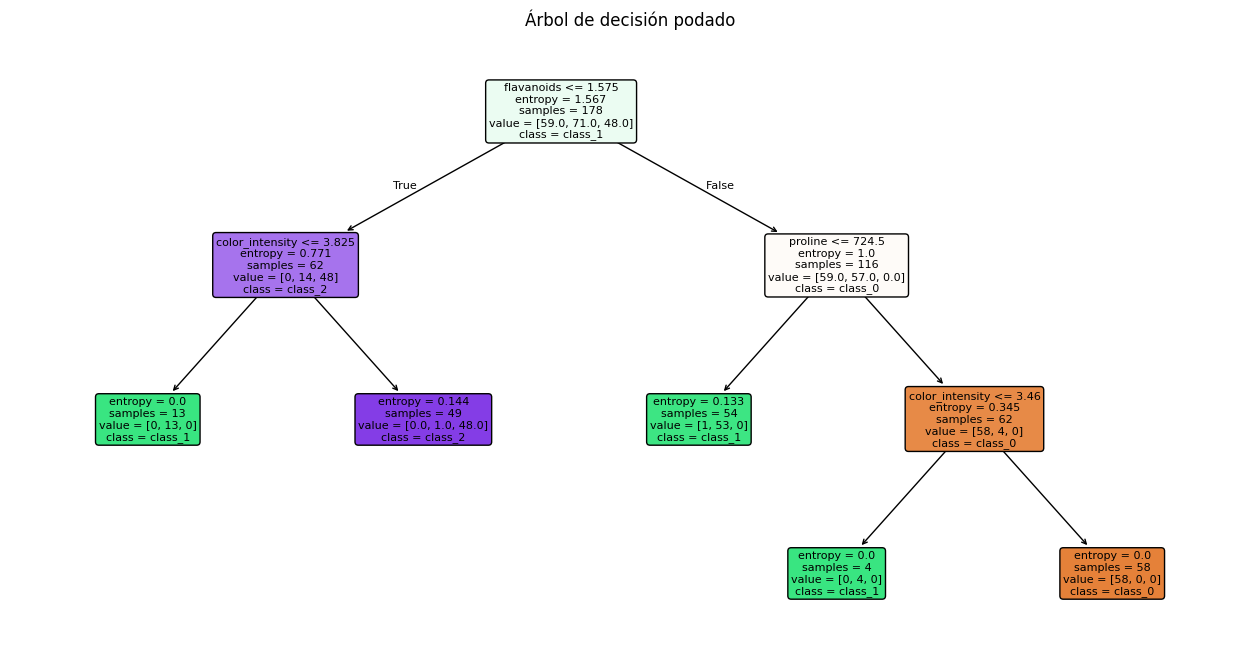

In [ ]:
# Diagrama del árbol
plt.figure(figsize=(16, 8))
plot_tree(
  dt_pruned,
  feature_names = feature_names,  # Nombres de cada una de las características
  class_names = target_names,     # Nombres de clase de destino en orden numérico ascendente
  label = 'all',                  # Etiquetas informativas sobre impurezas
  filled = True,                  # Pinta los nodos para indicar la clase mayoritaria
  rounded = True,                 # Cuadros de nodos con esquinas redondeadas
  fontsize = 8
)
plt.title("Árbol de decisión podado")
plt.show()

## Número de nodos y hojas

Se observa que el árbol podado posee 9 nodos de los cuales 5 son hojas.

In [ ]:
print(f"Árbol podado (α={alpha}) – nodos: {dt_pruned.tree_.node_count}, hojas: {dt_pruned.tree_.n_leaves}")

Árbol podado (α=0.05) – nodos: 9, hojas: 5


## Features más relevantes

Nuevamente, los features más importantes son `flavonoids`, `proline` y `color_intensity`. Que coincidan con las del árbol sin podar refuerza su valor discriminativo dentro del conjunto de datos.

In [ ]:
# Obtener los índices de las features ordenadas por importancia (de mayor a menor)
feature_importance_pruned_idx = np.argsort(dt_pruned.feature_importances_)[::-1]

# Seleccionar los índices de las 3 features más importantes
top3_feature_importance_pruned_idx = feature_importance_pruned_idx[:3]

# Obtener los nombres de las 3 features más importantes usando los índices
top3_feature_importance_names_pruned = [feature_names[i] for i in top3_feature_importance_pruned_idx ]


print("Features más relevantes:", top3_feature_importance_names_pruned)

Features más relevantes: ['flavanoids', 'proline', 'color_intensity']


## Predicción

El árbol podado mantiene la decisión final para la muestra, esto es `class_0`.

In [ ]:
pred_dt_pruned = dt_pruned.predict(sample)[0]
print("Predicción árbol podado:", target_names[pred_dt_pruned])

Predicción árbol podado: class_0


## Costo-Complejidad

Al aplicar la poda, el árbol resultante presentó una impureza promedio ponderada de aproximadamente 0.0799 y un costo complejidad total de 0.3299. Esto indica que, aunque la impureza promedio en las hojas se mantuvo baja (buen ajuste), la penalización por tener 5 hojas tiene un peso significativo. La poda, entonces, logró **simplificar la estructura del árbol**, manteniendo baja la impureza promedio y **favoreciendo la generalización**.

In [ ]:
# Costo-complejidad
# Crea una máscara booleana para identificar las hojas del árbol.
# Se consideran hojas aquellos nodos cuyo hijo izquierdo es -1 (no tiene hijo izquierdo).
is_leaf = dt_pruned.tree_.children_left == -1

# Calcula el costo (impureza promedio ponderada)
impurity_sum = (
    dt_pruned.tree_.impurity[is_leaf] * dt_pruned.tree_.n_node_samples[is_leaf]
).sum()
avg_impurity = impurity_sum / X.shape[0]

# Calcula el costo-complejidad total
cost_complexity = avg_impurity + alpha * dt_pruned.tree_.n_leaves

print(f"Impureza promedio: {avg_impurity:.4f} \nCosto-complejidad: {cost_complexity:.4f}")

Impureza promedio: 0.0799 
Costo-complejidad: 0.3299


#(d) Bosques aleatorios

Los Bosques Aleatorios son un **método de ensamble** (ensemble method). La idea principal es combinar las salidas de muchos "clasificadores débiles" para producir un "comité" potente. En este caso, los clasificadores débiles son **árboles de decisión**.

La construcción de un Bosque Aleatorio típicamente implica **crecer árboles sobre muestras boostrap** (remuestreo con reemplazo) de los datos de entrenamiento, un proceso conocido como **bagging**. Además del bagging, lo que los hace "aleatorios" es que en cada nodo, al seleccionar la mejor división (split), se elige de un **subconjunto aleatorio de características**.

El objetivo principal de combinar múltiples árboles y agregar aleatoriedad es **mejorar la predicción** en comparación con un solo árbol. Específicamente, los Bosques Aleatorios son conocidos por **evitar el sobreajuste** (overfitting) a los datos de entrenamiento y por **reducir la varianza** de las predicciones. La aleatoriedad, mediante la perturbación estocástica y el promediado, ayuda a proteger contra el sobreajuste. El promediado mantiene la esperanza y reduce la varianza en muestras i.i.d.:
$$\mathbf{E}\left[\frac{1}{B}\sum_{b=1}^B Z_b\right]=\mu\;\;\; \text{Var}\left(\frac{1}{B}\sum_{b=1}^B Z_B\right)=\frac{\sigma^2}{B}$$




## Implementación

In [ ]:
class RandomForest:
    """
    Bosque Aleatorio para clasificación.

    Args:
        n_estimators (int): Número de árboles en el bosque (default: 30).
        max_depth (int): Profundidad máxima de cada árbol (default: None, sin límite).
        criterion (str): Criterio para medir la calidad de una división ('gini' o 'entropy', default: 'entropy').
        max_features (int, float, or None): Número de features a considerar en cada split.
            - Si es int, entonces se consideran max_features features en cada split.
            - Si es 'sqrt', entonces max_features=sqrt(n_features).
            - Si es float, entonces max_features es una fracción.
            - Si es None, entonces max_features=n_features.
            (default: "sqrt").
        random_state (int): Semilla para la generación de números aleatorios (default: None).
    """
    def __init__(self, n_estimators=30, max_depth=None, criterion='entropy', max_features="sqrt", random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.criterion = criterion
        self.max_features = max_features
        self.random_state = random_state
        self.trees_ = []  # Lista para almacenar los árboles
        if random_state is not None:
            np.random.seed(random_state)  # Fijar la semilla para reproducibilidad

    def fit(self, X, y):
        """
        Entrena el Bosque Aleatorio.

        Args:
            X (array-like): Datos de entrenamiento (características).
            y (array-like): Etiquetas de entrenamiento.
        """
        self.trees_ = []  # Lista de árboles
        for _ in range(self.n_estimators):
            # 1. Crear una muestra bootstrap
            bootstrap_idx = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
            X_bootstrap, y_bootstrap = X[bootstrap_idx], y[bootstrap_idx]

            # 2. Crear y entrenar un árbol de decisión con la muestra bootstrap
            dt = DecisionTreeClassifier(
                criterion=self.criterion,
                max_depth=self.max_depth,
                max_features=self.max_features,
                random_state=self.random_state
            )
            dt.fit(X_bootstrap, y_bootstrap)

            # 3. Agregar el árbol al bosque
            self.trees_.append(dt)
        return self

    def predict(self, X):
        """
        Realiza predicciones sobre nuevos datos.

        Args:
            X (array-like): Datos de entrada (características).

        Returns:
            array-like: Predicciones del Bosque Aleatorio.
        """
        # Obtener predicciones de cada árbol
        tree_pred = [tree.predict(X) for tree in self.trees_]

        # Votación por mayoría (hard voting) para cada muestra
        final_preds = []
        for i in range(X.shape[0]):
            # Contar votos para cada clase
            votes = np.bincount(np.array(tree_pred)[:, i])

            # Seleccionar la clase con más votos
            final_preds.append(np.argmax(votes))

        return np.array(final_preds)

## Predicción

El bosque aleatorio implementado, compuesto por 30 árboles entrenados sobre subconjuntos bootstrap del conjunto original y seleccionando un subconjunto aleatorio de $\sqrt{p}$ features, predice que la muestra pertenece al productor 'class_1', en contraste con los árboles individuales (con y sin poda), que clasificaron la muestra como `class_0`.

La votación mayoritaria de los árboles permite capturar variaciones del conjunto de datos que un único árbol podría pasar por alto, lo que mejora la capacidad de generalización del modelo ante nuevos datos.

In [ ]:
# Crea un objeto RandomForest con 30 árboles, criterio de entropía,
# considerando la raíz cuadrada del número total de features en cada split,
# y una semilla aleatoria para la reproducibilidad.
rf = RandomForest(n_estimators=30, criterion='entropy', max_features='sqrt', random_state=0)

# Entrena el modelo RandomForest
rf.fit(X, y)

# Realiza una predicción
pred_rf = rf.predict(sample)[0]

# Imprime la predicción
print("Predicción Bosque Aleatorio:", target_names[pred_rf])

Predicción Bosque Aleatorio: class_1
